### Download the dataset and understand the format
In the next cell we download the data from the repo, extact, organize it and we delete the ```thumb.db``` files so it is not read as images with the ```os.listdir``` function

In [1]:
# download data

import tarfile
import os
from subprocess import call
from IPython.display import HTML, display


data_zip = 'BSR_bsds500.tgz'
data_dirc = "data"
if not os.path.isdir(data_dirc):
    print("data file not found.")
    print("checking if zip file exists")
    if not os.path.exists(data_zip):
        print("zip file does not exist.")
        print("downloading data...")
        url = "http://web.archive.org/web/20120508113820if_/http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
        filename = wget.download(url)
        print("download " + filename)
        print("data downloaded")
    else:
        print("Zip file exists")

    print("extracting data")
    tar = tarfile.open(data_zip, "r")
    tar.extractall()
    
    if not os.path.isdir(data_dirc):
        os.makedirs(data_dirc)
    
    os.popen('cp -r BSR/BSDS500/data/images/* data').read()
    os.popen('cp -r BSR/BSDS500/data/groundTruth data/').read()
    os.remove('data/train/Thumbs.db')

else:
    print("data found")
    
os.system('rm -rf $(find -name "thumb.db")')
    
import sys


def progress_bar(value, max, status=''):
    return HTML(("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress> <label> {status} </label>
    """).format(value=value, max=max, status=status))



data found


### Visualize the image and the ground truth segmentation
The next cell contains a function that reads the .mat file which represent the groundTruth segmentation and plots it

In [2]:
import scipy.io
import matplotlib.pyplot as plt
from matplotlib.image import imread

dirc_truth = os.path.join(data_dirc, 'groundTruth')

def show_image_groundTrue(image_path):
    
    fig = plt.figure(figsize=(20, 7))
    fig.subplots_adjust(hspace=0.0, wspace=0.01)
    n = 2
    m = 4
    j = 1
    img = imread(os.path.join(data_dirc, image_path))
    fig.add_subplot(n, m, j)
    j = j + 1
    plt.axis('off')
    plt.imshow(img)
    
    image_path = image_path.replace('jpg', 'mat')
    mat = scipy.io.loadmat(os.path.join(dirc_truth, image_path))
    
    for i in range(0, 3):
        x = mat['groundTruth'][0][i][0][0][1]
        fig.add_subplot(n, m, j)
        plt.axis('off')
        plt.imshow(x)
        j = j + 1

    j = j + 1
    for i in range(0, 3):
        x = mat['groundTruth'][0][i][0][0][0]
        fig.add_subplot(n, m, j)
        plt.axis('off')
        plt.imshow(x)
        j = j + 1

    plt.show()
    
pyramid_image = "299091.jpg"
show_image_groundTrue(os.path.join('train', pyramid_image))


<Figure size 2000x700 with 7 Axes>

### Segmentation using K-means
The next cell provides a function that takes the image and the number of clusters as parameters to perform the image segmentation using K-means algorithm.

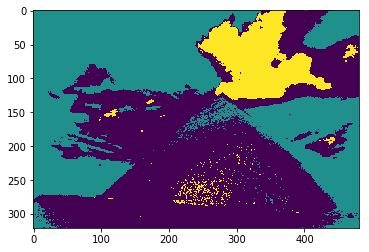

In [3]:
# kmeans
from sklearn.cluster import KMeans

def kmeans_cluster(img, n_clusters):
    
    n = img.shape[0]
    m = img.shape[1]
    colors = img.shape[2]
    
    img = img.reshape(n * m, colors) # n * m rows each with a vector of RGB
    kmeans = KMeans(n_clusters=n_clusters, precompute_distances=True,n_jobs=-1).fit(img)
    
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
#     for i in range(0, n * m):
#         img[i] = centers[labels[i]]
    
    labels = labels.reshape(n, m)
    return labels


dirc_train = os.path.join(data_dirc, "train")
dirc_kmeans = os.path.join(data_dirc, "kmeans")

img = imread(os.path.join(dirc_train, pyramid_image))
img.flags.writeable = True
result = kmeans_cluster(img, 3)
plt.imshow(result)
plt.show()
# print(result)







#### Running  the algorithm for k in {3, 5, 7, 9, 11} :
The following cell introduces a function that performs the segmentation using K-means method on all the dataset and using k = {3, 5, 7, 9, 11}. It depends on ```kmeans_cluster(img, n_clusters):``` to run the K-means. Also the results are saved in the ```kmeans/$(run_number)/$(cluster_number)``` directory.

In [20]:
import numpy as np
import imageio

def kmeans_images(original_path, result_path, segs):
    print("processing images in " + original_path + " writing result to " + result_path +
         " for clusters " + str(segs))
    
    images = os.listdir(original_path)
    n = len(images)
    i = 1
    bar = display(progress_bar(0, n), display_id=True)
    for image in images:
        i = i + 1
        
        img = imread(os.path.join(original_path, image))
        for seg in segs:
            bar.update(progress_bar(i, n, "Image= {image}, Seg= {seg}".format(image=image,seg=seg)))
            dirc = os.path.join(result_path, str(seg))
            if not os.path.exists(dirc):
                os.makedirs(dirc)
                
            c = np.copy(img)
            result = kmeans_cluster(c, seg)
            np.save(os.path.join(dirc, image), result)
        
    print("kmeans done")

n_tirals = 1
for i in range(1, n_tirals + 1):
    print("run number: " + str(i))
    f = "run_" + str(i)
    kmeans_images(dirc_train, os.path.join(dirc_kmeans, f), [3,5,7,9,11])








run number: 1
processing images in data/train writing result to data/kmeans/run_1 for clusters [3, 5, 7, 9, 11]
kmeans done==================================================] 200/200 ...100080.jpg


#### Plot results for different clusters.
The following cell uses the pyramid image as a sample to show the segmentation results for different values of k. We can notice the the more clusters we add the more details we can see in the result.

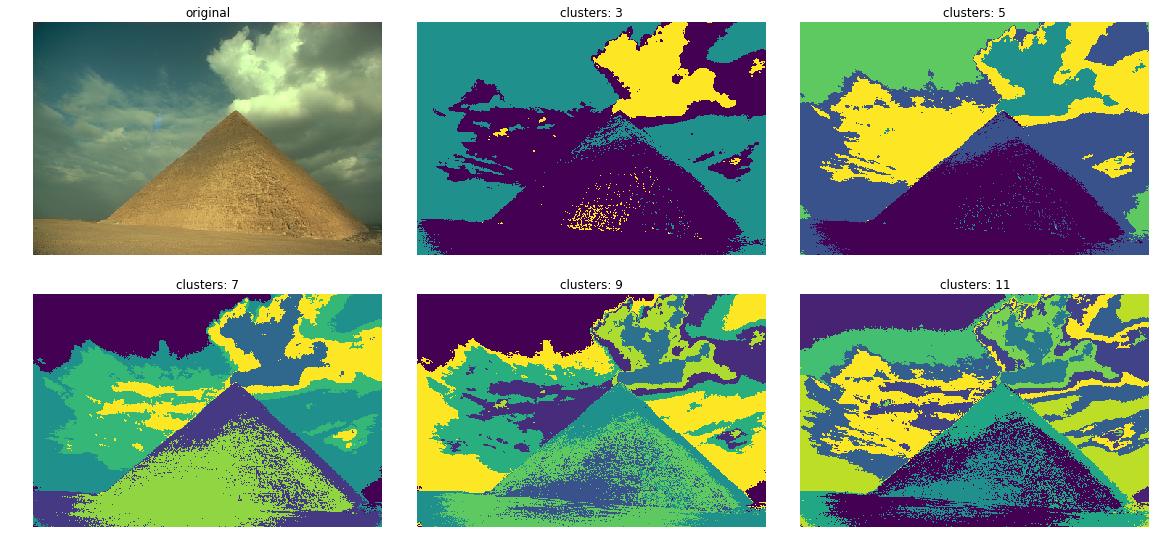

In [4]:
# display image and it's segmentation
import numpy as np
from matplotlib.image import imread
import matplotlib.pyplot as plt

def visualize(image_name, original_path, segmentation_path, segs):

    img = imread(os.path.join(original_path, image_name))

    
    fig = plt.figure(figsize=(20, 10))
    fig.subplots_adjust(hspace=0.0, wspace=0.1)
    
    l = len(segs) + 1
    n = 2
    m = l // n
    
    fig.add_subplot(n, m, 1)
    plt.axis('off')
    plt.title('original')
    plt.imshow(img)
    
    i = 2
    for f in segs:
        img = np.load(os.path.join(segmentation_path, f, image_name + ".npy"))
        fig.add_subplot(n, m, i)
        plt.axis('off')
        plt.title('clusters: ' + f)
        plt.imshow(img)
        
        i = i + 1
        
#     plot(img)
    plt.show()

dirc_train = os.path.join(data_dirc, "train")
dirc_kmeans = os.path.join(data_dirc, "kmeans")
pyramid_image = "299091.jpg"
segs = ["3", "5", "7", "9", "11"]
visualize(pyramid_image, dirc_train, os.path.join(dirc_kmeans, "run_1"), ["3", "5", "7", "9", "11"])





#### f_measure and conditional Entropy.
The next two cells provide an implementation for the segmentation results.
* The first cell provides an implementation for the f_measure as shown in the lecture slides.
* The second cell provides an implementation for the conditional entropy as shown in the lecture slides.

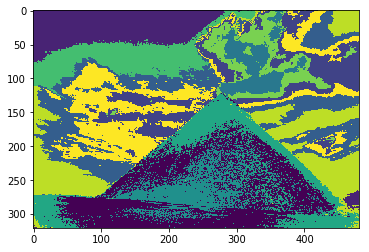

C:\Users\Blu-Ray\Anaconda3\envs\cs231n\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Blu-Ray\Anaconda3\envs\cs231n\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to int16
  .format(dtypeobj_in, dtypeobj_out))


[0 0 0 ... 2 2 2]
0.804483188044832


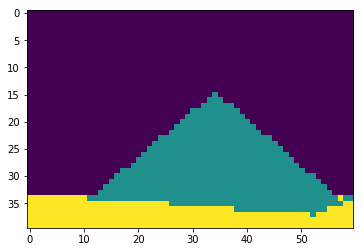

In [123]:
# F-measure
from skimage import img_as_uint
from skimage.filters import sobel
from skimage.transform import resize

def cluster_freq(clusters, truth):
    freq = {}
    g = {}
    for c, t in zip(clusters, truth):
        if not c in freq:
            freq[c] = {}
        
        if not t in freq[c]:
            freq[c][t] = 0
        
        freq[c][t] = freq[c][t] + 1
        
        if not t in g:
            g[t] = 0
        g[t] = g[t] + 1
        
    return (freq, g)


# clusters and truth are two dimention arrays
def f_measure(clusters, truth):
    
    (n, m) = clusters.shape
    (nn, mm) = truth.shape
    clusters = resize(clusters, (n, m),anti_aliasing=False)
    clusters = img_as_int(clusters);
    clusters = clusters.reshape(n * m)
    truth = resize(truth, (n, m),anti_aliasing=False)
    truth = img_as_int(truth);
    truth = truth.reshape(n * m)
    # map of cluster id (from clusters) to a map of cluster id (from truth)
    # and it's frequency
    (freq, g) = cluster_freq(clusters, truth)
    
    f_score = 0
    n = 0
    for k, v in freq.items(): # for each cluster
        total = 0
        max_index = -1
        max_count = -1
        
        for a, f in v.items():
            total = total + f
            if(f > max_count):
                max_count = f
                max_index = a
                
        prec = max_count * 1.0 / total
        rec = max_count / g[max_index]
        
        f = 2.0 * (prec * rec) / (prec + rec)
        f_score = f_score + f
        
        n = n + 1
        
    f_score = f_score / n
    
    return f_score
    
img = np.load(os.path.join(dirc_kmeans, "run_1", "11", pyramid_image + ".npy"))
mat = scipy.io.loadmat(os.path.join(dirc_truth, "train", pyramid_image.replace('jpg', 'mat')))


# assert f_measure(mat['groundTruth'][0][0][0][0][0], mat['groundTruth'][0][0][0][0][0]) == 1

plt.imshow(img)
plt.show()

f = f_measure(img, mat['groundTruth'][0][0][0][0][0])
print(f)





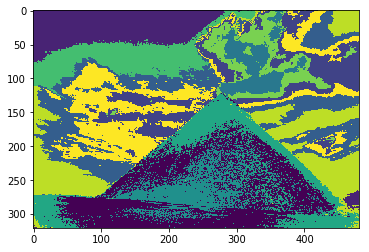

0.3133014886903224


In [6]:
#  Conditional Entropy

# clusters and truth are two dimention arrays
import math
def conditional_entropy(clusters, truth):

    ((n, m) = clusters.shape
    (nn, mm) = truth.shape
    clusters = resize(clusters, (n, m),anti_aliasing=False)
    clusters = img_as_int(clusters);
    clusters = clusters.reshape(n * m)
    truth = resize(truth, (n, m),anti_aliasing=False)
    truth = img_as_int(truth);
    truth = truth.reshape(n * m)
    
    (freq, g) = cluster_freq(clusters, truth)
    
    ht = 0
    
    for k, v in freq.items():
        t = 0.0 # total elements in cluster
        for a, b in v.items():
            t = t + b
        
        x = 0
        for a, b in v.items():
    
            l = - (b / t) * (math.log(b / t))
            x = x + l
        
        ht += x * t / size
    
    return ht
    

img = np.load(os.path.join(dirc_kmeans, "run_1", "11", pyramid_image + ".npy"))
mat = scipy.io.loadmat(os.path.join(dirc_truth, "train", pyramid_image.replace('jpg', 'mat')))

assert conditional_entropy(img, img) == 0


plt.imshow(img)
plt.show()

f = conditional_entropy(img, mat['groundTruth'][0][0][0][0][0])
print(f)





#### Report results and performance comparisopn
The next 3 cells provide functions that are used to report the run results using f_measure an conditional entropy as performance measure.
* The first cell is creates a map object that will be used to create the report table.
* The second cell creates the report table.
* The third cell shows a comparison between the groundTruth segmentation and the K-means segmenetation

In [7]:
# image metrics

def image_metrics(original_path, result_path, image_name, segs):
    
    ground_truth = os.path.join(data_dirc, 'groundTruth', original_path, image_name.replace('jpg', 'mat'))
    mat = scipy.io.loadmat(ground_truth)
    
    gt = []
    gt.append(mat['groundTruth'][0][0][0][0][0])
    gt.append(mat['groundTruth'][0][1][0][0][0])
    gt.append(mat['groundTruth'][0][2][0][0][0])
    
    result = {}
    
    for seg in segs:
        img = np.load(os.path.join(result_path, seg, image_name + ".npy"))
        r = {'f_measure' : {'best':0, 'worst': 1, 'average':0},
             'entropy':{'best':0, 'worst': 1, 'average':0}}
    
        i = 1
        for g in gt:
            k = "groundTruth_" + str(i)
            i = i + 1
            
            f1 = f_measure(img, g)
            r['f_measure'][k] = f1
            r['f_measure']['best'] = max(r['f_measure']['best'], f1)
            r['f_measure']['worst'] = min(r['f_measure']['worst'], f1)
            r['f_measure']['average'] = r['f_measure']['average'] + f1
            
            f2 =  conditional_entropy(img, g)
            r['entropy'][k] = f2
            r['entropy']['best'] = max(r['entropy']['best'], f2)
            r['entropy']['worst'] = min(r['entropy']['worst'], f2)
            r['entropy']['average'] = r['entropy']['average'] + f2
            
        r['f_measure']['average'] = r['f_measure']['average'] / 3  
        r['entropy']['average'] = r['entropy']['average'] / 3
            
        result[seg] = r
        
    return result
    

metrics = image_metrics("train", os.path.join(dirc_kmeans, "run_1"), pyramid_image, segs)
print(metrics)
    
    

{'3': {'f_measure': {'best': 0.49879754792332703, 'worst': 0.39128137986302, 'average': 0.4386761106209294, 'groundTruth_1': 0.39128137986302, 'groundTruth_2': 0.49879754792332703, 'groundTruth_3': 0.42594940407644133}, 'entropy': {'best': 0.9366937153601234, 'worst': 0.6691552659874161, 'average': 0.7602414386402692, 'groundTruth_1': 0.9366937153601234, 'groundTruth_2': 0.6748753345732681, 'groundTruth_3': 0.6691552659874161}}, '5': {'f_measure': {'best': 0.6026879580462917, 'worst': 0.4509462675330439, 'average': 0.5020091719536768, 'groundTruth_1': 0.6026879580462917, 'groundTruth_2': 0.45239329028169495, 'groundTruth_3': 0.4509462675330439}, 'entropy': {'best': 0.47900265425538796, 'worst': 0.3831306452791894, 'average': 0.4173473310463194, 'groundTruth_1': 0.47900265425538796, 'groundTruth_2': 0.38990869360438074, 'groundTruth_3': 0.3831306452791894}}, '7': {'f_measure': {'best': 0.5081869989452719, 'worst': 0.3920468945431247, 'average': 0.4313606158851046, 'groundTruth_1': 0.508

In [8]:

# from prettytable import PrettyTable
    
# x = PrettyTable()

# x.field_names = ["City name", "Area", "Population", "Annual Rainfall"]

# x.add_row(["Adelaide", 1295, 1158259, 600.5])
# x.add_row(["Brisbane", 5905, 1857594, 1146.4])
# x.add_row(["Darwin", 112, 120900, 1714.7])
# x.add_row(["Hobart", 1357, 205556, 619.5])
# x.add_row(["Sydney", 2058, 4336374, 1214.8])
# x.add_row(["Melbourne", 1566, 3806092, 646.9])
# x.add_row(["Perth", 5386, 1554769, 869.4])

# print(x)
from IPython.display import HTML, display
from tabulate import tabulate

def image_metrics_report(original_path, result_path, image_name, segs):

    report = image_metrics(original_path, result_path, image_name, segs)
#     print(report)
    
    rd = 5
    
    for seg in segs:
        d = report[seg]

        table = [["clusters: " + seg, "groundTruth_1","groundTruth_2", "groundTruth_3",
                 "best", "worst", "average"],
             ["f_measure"],
             ["entropy"]]

        for i in range(1, len(table[0])):
            table[1].append(round(d["f_measure"][table[0][i]], rd))

        for i in range(1, len(table[0])):
            table[2].append(round(d["entropy"][table[0][i]], rd))

        display(HTML(tabulate(table, tablefmt='html')))

    

  
    
image_metrics_report("train", os.path.join(dirc_kmeans, "run_1"), pyramid_image, segs)




# table = [["Sun",696000,1989100000],
#          ["Earth",6371,5973.6],
#          ["Moon",1737,73.5],
#          ["Mars",3390,641.85]]
# display(HTML(tabulate.tabulate(table, tablefmt='html')))






clusters: 3,groundTruth_1,groundTruth_2,groundTruth_3,best,worst,average
f_measure,0.39128,0.4988,0.42595,0.4988,0.39128,0.43868
entropy,0.93669,0.67488,0.66916,0.93669,0.66916,0.76024


clusters: 5,groundTruth_1,groundTruth_2,groundTruth_3,best,worst,average
f_measure,0.60269,0.45239,0.45095,0.60269,0.45095,0.50201
entropy,0.479,0.38991,0.38313,0.479,0.38313,0.41735


clusters: 7,groundTruth_1,groundTruth_2,groundTruth_3,best,worst,average
f_measure,0.50819,0.39385,0.39205,0.50819,0.39205,0.43136
entropy,0.34479,0.2581,0.25563,0.34479,0.25563,0.28617


clusters: 9,groundTruth_1,groundTruth_2,groundTruth_3,best,worst,average
f_measure,0.42107,0.33123,0.32963,0.42107,0.32963,0.36064
entropy,0.32729,0.23715,0.23595,0.32729,0.23595,0.26679


clusters: 11,groundTruth_1,groundTruth_2,groundTruth_3,best,worst,average
f_measure,0.38065,0.27785,0.27696,0.38065,0.27696,0.31182
entropy,0.3133,0.24636,0.2442,0.3133,0.2442,0.26795


As we can see in the results above. As we increase the number of clusters the f_measure and the conditional Entropy decreases which is a measure that the we are getting better results.

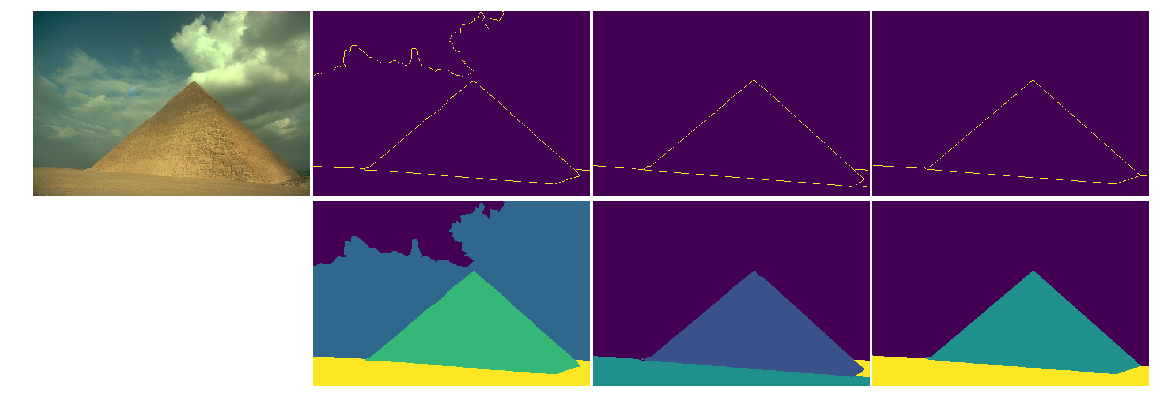

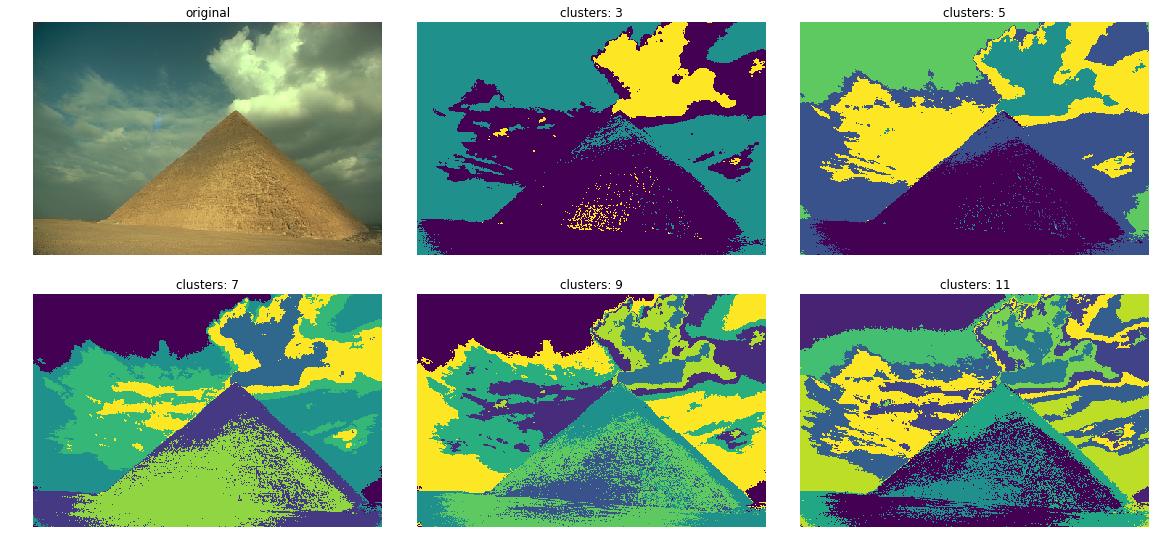

clusters: 3,groundTruth_1,groundTruth_2,groundTruth_3,best,worst,average
f_measure,0.39128,0.4988,0.42595,0.4988,0.39128,0.43868
entropy,0.93669,0.67488,0.66916,0.93669,0.66916,0.76024


clusters: 5,groundTruth_1,groundTruth_2,groundTruth_3,best,worst,average
f_measure,0.60269,0.45239,0.45095,0.60269,0.45095,0.50201
entropy,0.479,0.38991,0.38313,0.479,0.38313,0.41735


clusters: 7,groundTruth_1,groundTruth_2,groundTruth_3,best,worst,average
f_measure,0.50819,0.39385,0.39205,0.50819,0.39205,0.43136
entropy,0.34479,0.2581,0.25563,0.34479,0.25563,0.28617


clusters: 9,groundTruth_1,groundTruth_2,groundTruth_3,best,worst,average
f_measure,0.42107,0.33123,0.32963,0.42107,0.32963,0.36064
entropy,0.32729,0.23715,0.23595,0.32729,0.23595,0.26679


clusters: 11,groundTruth_1,groundTruth_2,groundTruth_3,best,worst,average
f_measure,0.38065,0.27785,0.27696,0.38065,0.27696,0.31182
entropy,0.3133,0.24636,0.2442,0.3133,0.2442,0.26795


In [9]:


def image_report(original_path, result_path, image_name, segs):
    
    show_image_groundTrue(os.path.join(original_path, image_name))

    visualize(image_name, os.path.join(data_dirc,original_path),
             result_path, segs)
    
    image_metrics_report(original_path, result_path, image_name, segs)
    
    
image_report("train", os.path.join(dirc_kmeans, "run_1"), pyramid_image, segs)
    

**Normalized Cut** 
- Normalized cut is also known by spectral clustering.
- Here n the spectral_cluster method, it performs the spectral clustering with certain paramaters:
 - n_clusters: the number of clusters.
 - tpe: the type of spectral clustering either rbf or nearest_neighbor
- At the begining the size of the image is changed because it consumes alot of memory space if it is represented in its original size.
- The method SpectralClustering() in sklearn is used in spectral clustering.
- The SpectralClustering() methos accepts only 2d wrapped images images so the image will be reshapped.  

C:\Users\Blu-Ray\Anaconda3\envs\cs231n\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Blu-Ray\Anaconda3\envs\cs231n\lib\site-packages\sklearn\manifold\spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


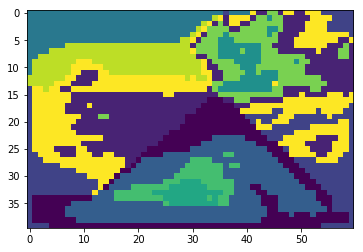

[[4 4 4 ... 2 2 2]
 [4 4 4 ... 2 2 2]
 [4 4 4 ... 2 2 2]
 ...
 [2 0 0 ... 0 0 2]
 [2 0 0 ... 0 0 2]
 [2 2 2 ... 2 2 2]]


In [127]:
from sklearn.cluster import SpectralClustering
from skimage.transform import resize

def spectral_cluster(img, n_clusters, tpe, gamma=1):
    img = resize(img, (40, 60), anti_aliasing=True)
    n = img.shape[0]
    m = img.shape[1]
    colors = img.shape[2]
    img = img.reshape(n * m, colors) 
    spectral = SpectralClustering(n_clusters=n_clusters,
                       gamma=gamma, affinity=tpe, 
                       n_neighbors=5,
                       n_jobs=-1).fit(img)    
    labels = spectral.labels_
    labels = labels.reshape(n, m)
    return labels

dirc_normalized_rbf = os.path.join(data_dirc, "normalized_rbf")
dirc_normalized_nn = os.path.join(data_dirc, "normalized_nn") 
img = imread(os.path.join(dirc_train, pyramid_image))
img.flags.writeable = True
result = spectral_cluster(img, 11, 'nearest_neighbors', 1)
# np.save(os.path.join(dirc_normalized_nn, 'run_1', '5_1', pyramid_image), result)
plt.imshow(result)
plt.show()
print(result)

**Two ways for normalized cut**
- The two ways for the normalized cut is:
 - rbf with gamma values [1, 10].
 - Nearest neighbor method.
- Here in this method, all the images in the data set is processed using spectral clustering.
- Here the normalized cut is tested with rbf and nearest neighbor with 3 5 7 9 11 clusters.
- Tt is  tested with two values for gamma 1 and 10.
- The images with gamma = 10 is more sharmer and obvious than gamma = 1.

In [ ]:
def normalized_cut_images(original_path, result_path, segs, tpe, gamma):
    print("processing images in " + original_path + " writing result to " + result_path +
         " for clusters " + str(segs))
    images = [line.rstrip('\n') for line in open('normalized_train.txt')]

    n = len(images)
    i = 1
    bar = display(progress_bar(0, n), display_id=True)
    for image in images:
        i = i + 1
        img = imread(os.path.join(original_path, image))
        for seg in segs:
            bar.update(progress_bar(i, n, "Image= {image}, Seg= {seg}".format(image=image,seg=seg)))
            dirc = os.path.join(result_path, str(seg) + "_" + str(gamma))
            if not os.path.exists(dirc):
                os.makedirs(dirc)
            c = np.copy(img)
            result = spectral_cluster(c, seg, tpe, gamma)
            np.save(os.path.join(dirc, image), result)
    print("normalized_cut_done with " + tpe)

dirc_normalized_rbf = os.path.join(data_dirc, "normalized_rbf")
dirc_normalized_nn = os.path.join(data_dirc, "normalized_nn")
# normalized_cut_images(dirc_train, os.path.join(dirc_normalized_rbf, "run_1"), [3,5,7,9,11], 'rbf', 1)
normalized_cut_images(dirc_train, os.path.join(dirc_normalized_nn, "run_1"), [3,5,7,9,11], 'nearest_neighbors', 1)
normalized_cut_images(dirc_train, os.path.join(dirc_normalized_rbf, "run_1"), [3,5,7,9,11], 'rbf', 10)
normalized_cut_images(dirc_train, os.path.join(dirc_normalized_rbf, "run_1"), [3,5,7,9,11], 'rbf', 1)

processing images in data\train writing result to data\normalized_nn\run_1 for clusters [3, 5, 7, 9, 11]


C:\Users\Blu-Ray\Anaconda3\envs\cs231n\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Blu-Ray\Anaconda3\envs\cs231n\lib\site-packages\sklearn\manifold\spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


normalized_cut_done with nearest_neighbors
processing images in data\train writing result to data\normalized_rbf\run_1 for clusters [3, 5, 7, 9, 11]


normalized_cut_done with rbf
processing images in data\train writing result to data\normalized_rbf\run_1 for clusters [3, 5, 7, 9, 11]


**Comparison**
- A comparison between the resultant image from rbf with gamma 1 and 10 and nearset neighbor is run.
- The number of clusters used = 11.
- The most sharper and obvious is rbf with gamma = 10
- Then rbf with gamma = 1.
- Then nearest neighbor.

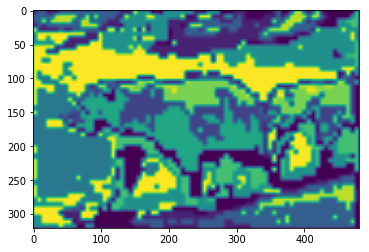

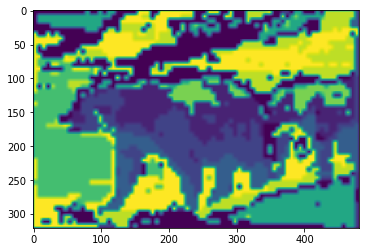

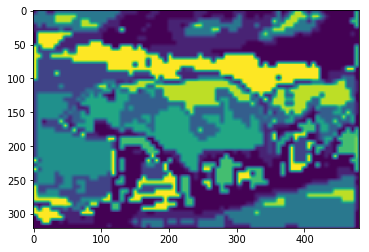

In [31]:
image = '100075.jpg'
img1 = np.load(os.path.join(dirc_normalized_rbf, "run_1", "11_10", image + ".npy"))
img2 = np.load(os.path.join(dirc_normalized_rbf, "run_1", "11_1", image + ".npy"))
img3 = np.load(os.path.join(dirc_normalized_nn , "run_1", "11_1", image + ".npy"))
mat = scipy.io.loadmat(os.path.join(dirc_truth, "train", image.replace('jpg', 'mat')))

plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()
plt.imshow(img3)
plt.show()

**Measuring the conditional entropy**
- As the conditional entropy decrease, this means that there is a better image.
- The conditional entropy is calculated for rbf 10 and nearest neighbor.
- The conditional entropy is nearly similar between them.

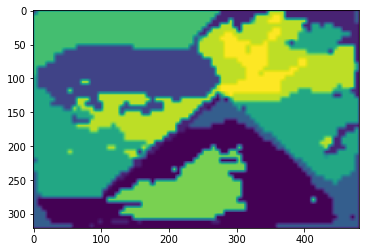

rbf entropy
0.3882295645997995
0.34006952382311745
0.2349570339585242
0.5318304691499154
0.11658052244234493
0.44176952253652974
0.07192754577790261
0.005654013929219719
0.24330328381416771
0.2633392674775713
0.06356817694220382
0.24640208883371958
0.4470792984081819
0.14779837526894687
0.2309929745792425
0.05384457111079025
0.3107145421928636
0.4610361081206303
0.18331194560793337
1.5882137819762923
0.9300191228228027
0.5113601785617403
0.9972928385923974
1.5294848147977214
0.5616385454325658
0.30498477109023936
2.0967593833806837
0.9050199247324496
0.9108414866846781
1.0697332123797962
nn entropy
0.3882295645997995
0.34006952382311745
0.2349570339585242
0.5318304691499154
0.11658052244234493
0.44176952253652974
0.07192754577790261
0.005654013929219719
0.24330328381416771
0.2633392674775713
0.06356817694220382
0.24640208883371958
0.4470792984081819
0.14779837526894687
0.2309929745792425
0.05384457111079025
0.3107145421928636
0.4610361081206303
0.18331194560793337
1.5882137819762923
0.

In [32]:
img = np.load(os.path.join(dirc_normalized_rbf, "run_1", "11_1", pyramid_image + ".npy"))
mat = scipy.io.loadmat(os.path.join(dirc_truth, "train", pyramid_image.replace('jpg', 'mat')))

plt.imshow(img)
plt.show()

def entropy(path, sub):
    images = os.listdir(dirc_train)
    for image in images:
        img = np.load(os.path.join(dirc_normalized_rbf, "run_1", "11_1", image + ".npy"))
        mat = scipy.io.loadmat(os.path.join(dirc_truth, "train", image.replace('jpg', 'mat')))
        f = conditional_entropy(img, mat['groundTruth'][0][0][0][0][0])
        if(f > 0):
            print(f)
print("rbf entropy")
entropy(dirc_normalized_rbf, '11_10')
print("nn entropy")
entropy(dirc_normalized_nn, '11_1')

**Measuring the f-measure**
- As the f-measure increases, this means that there is a better image.
- The f-measure is calculated for rbf 10 and nearest neighbor.
- The f-measure is nearly similar between them.

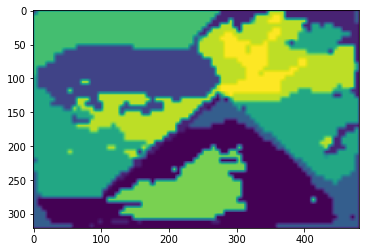

rbf entropy
0.0003697190277581026 100075.jpg
0.00048138206273349405 108041.jpg
0.0011083602584075545 161062.jpg
0.0007068336645588809 170054.jpg
0.00011798135716233182 26031.jpg
0.0005238762190689487 27059.jpg
0.00017530036933898922 28075.jpg
5.094783155104387e-05 28096.jpg
0.00017919636551728694 299091.jpg
0.0004774598495521695 33066.jpg
0.00019313120628086224 35008.jpg
0.0005762899123451121 35010.jpg
0.00015651515034893233 35058.jpg
0.00021155469144392577 35070.jpg
0.0005589655825304964 35091.jpg
0.00026269763207124983 41004.jpg
0.00042142828937483096 41025.jpg
0.00019578693581986844 42044.jpg
0.00018553494696271587 42078.jpg
0.1531613779047607 43070.jpg
0.1487809516669865 43083.jpg
0.14773652576871246 45077.jpg
0.162644281076759 46076.jpg
0.16170244816053983 48055.jpg
0.1579030537452629 54005.jpg
0.15272671596842302 55067.jpg
0.15469261360691128 55075.jpg
0.15149074282209 56028.jpg
0.13571716397864184 59078.jpg
0.1426920113968827 60079.jpg
0.15391167599102043 61060.jpg
0.15528144299

In [33]:
img = np.load(os.path.join(dirc_normalized_rbf, "run_1", "11_1", pyramid_image + ".npy"))
mat = scipy.io.loadmat(os.path.join(dirc_truth, "train", pyramid_image.replace('jpg', 'mat')))

plt.imshow(img)
plt.show()

def f(path, sub):
    images = os.listdir(dirc_train)
    for image in images:
        img = np.load(os.path.join(dirc_normalized_rbf, "run_1", "11_1", image + ".npy"))
        mat = scipy.io.loadmat(os.path.join(dirc_truth, "train", image.replace('jpg', 'mat')))
        f = f_measure(img, mat['groundTruth'][0][0][0][0][0])
        if(f > 0):
            print(str(f) + " " + image)
print("rbf entropy")
f(dirc_normalized_rbf, '11_10')
print("nn entropy")
f(dirc_normalized_nn, '11_1')


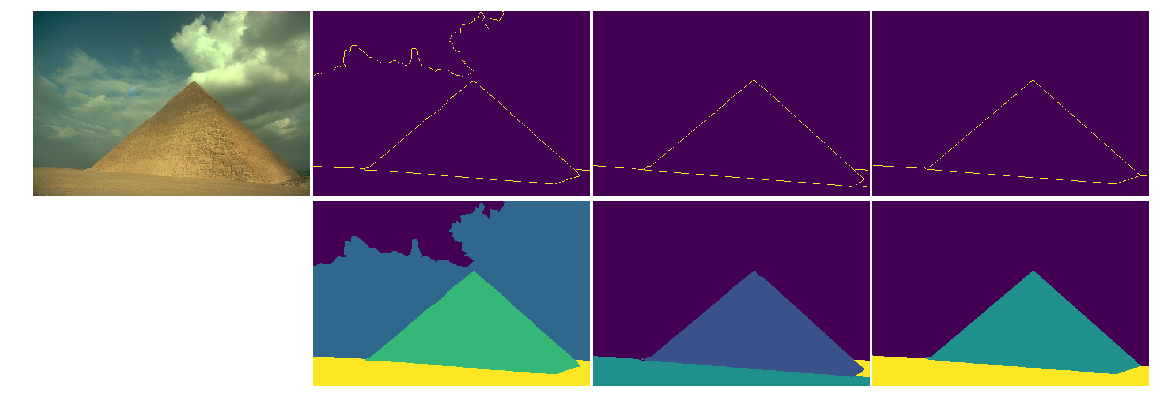

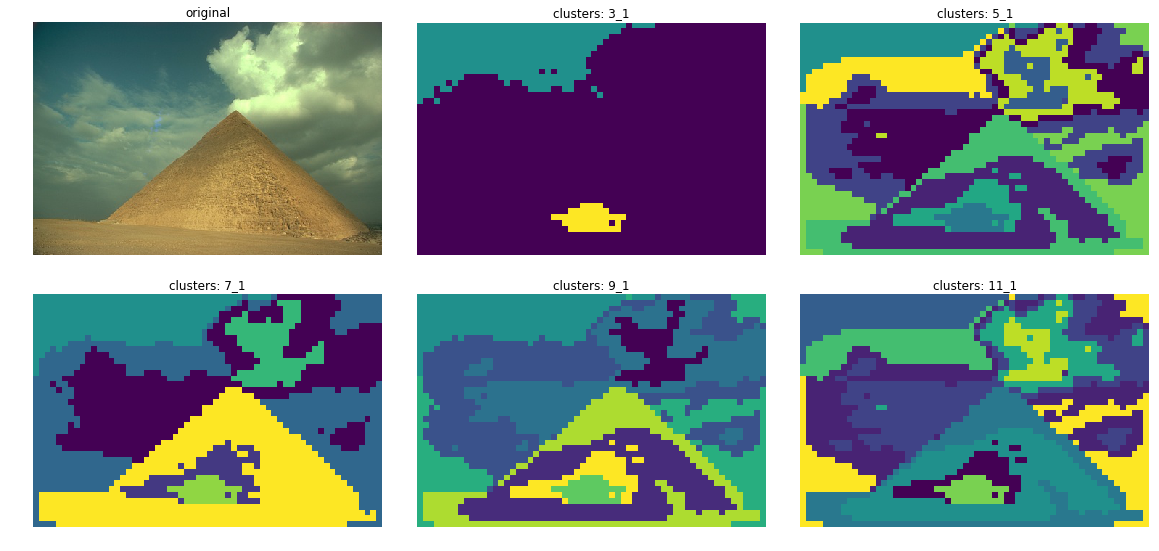

clusters: 3_1,groundTruth_1,groundTruth_2,groundTruth_3,best,worst,average
f_measure,0.35177,0.39923,0.39923,0.39923,0.35177,0.38341
entropy,0.60947,0.0,0.0,0.60947,0.0,0.20316


clusters: 5_1,groundTruth_1,groundTruth_2,groundTruth_3,best,worst,average
f_measure,0.16,0.16265,0.16265,0.16265,0.16,0.16177
entropy,0.58688,0.0,0.0,0.58688,0.0,0.19563


clusters: 7_1,groundTruth_1,groundTruth_2,groundTruth_3,best,worst,average
f_measure,0.21951,0.2359,0.2359,0.2359,0.21951,0.23043
entropy,0.6062,0.0,0.0,0.6062,0.0,0.20207


clusters: 9_1,groundTruth_1,groundTruth_2,groundTruth_3,best,worst,average
f_measure,0.18229,0.19324,0.19324,0.19324,0.18229,0.18959
entropy,0.6013,0.0,0.0,0.6013,0.0,0.20043


clusters: 11_1,groundTruth_1,groundTruth_2,groundTruth_3,best,worst,average
f_measure,0.16,0.16265,0.16265,0.16265,0.16,0.16176
entropy,0.58675,0.0,0.0,0.58675,0.0,0.19558


In [19]:
image_report("train", os.path.join(dirc_normalized_nn, "run_1"), pyramid_image, ['3_1', '5_1', '7_1', '9_1', '11_1'])

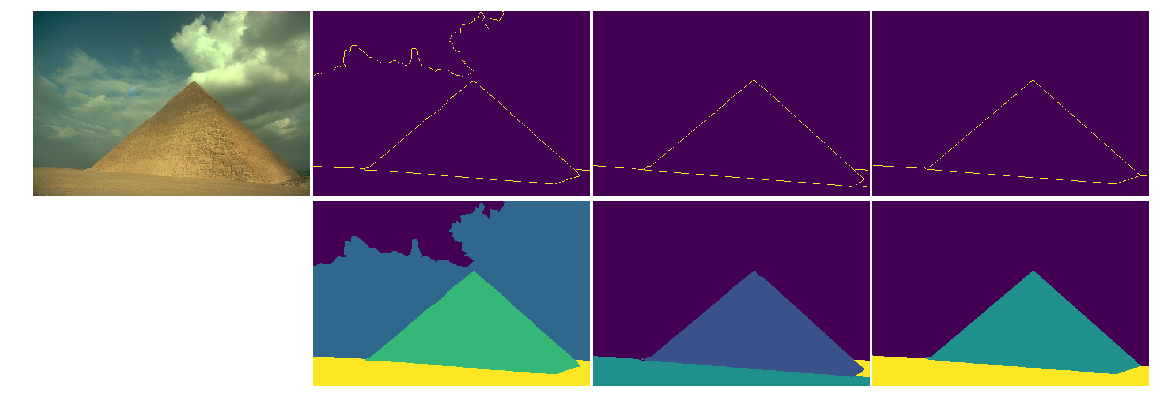

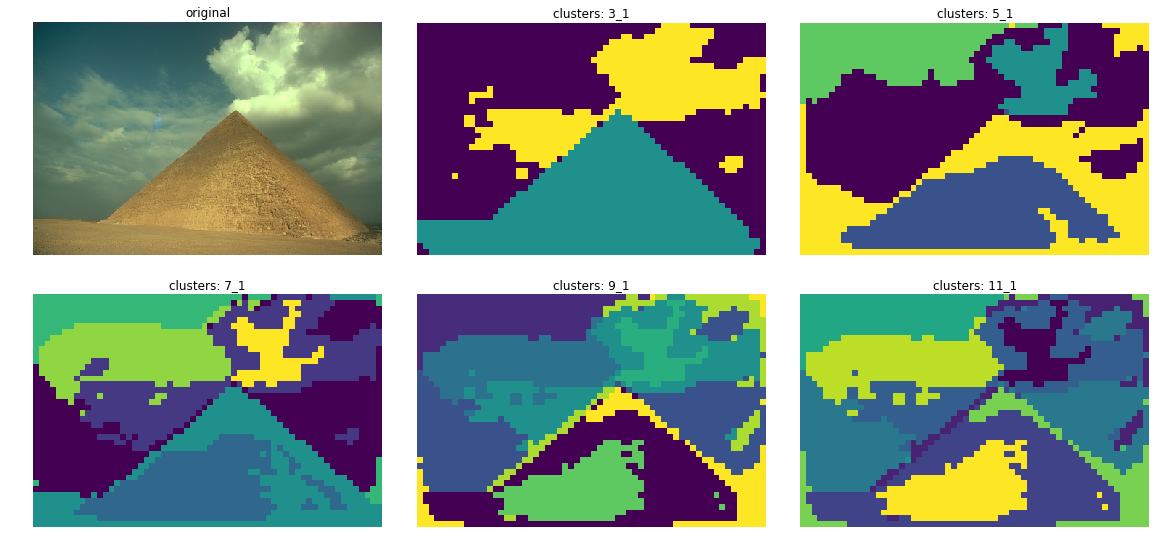

clusters: 3_1,groundTruth_1,groundTruth_2,groundTruth_3,best,worst,average
f_measure,0.43672,0.49013,0.49013,0.49013,0.43672,0.47233
entropy,0.61728,0.0,0.0,0.61728,0.0,0.20576


clusters: 5_1,groundTruth_1,groundTruth_2,groundTruth_3,best,worst,average
f_measure,0.29712,0.32256,0.32256,0.32256,0.29712,0.31408
entropy,0.60475,0.0,0.0,0.60475,0.0,0.20158


clusters: 7_1,groundTruth_1,groundTruth_2,groundTruth_3,best,worst,average
f_measure,0.24023,0.24517,0.24517,0.24517,0.24023,0.24352
entropy,0.58849,0.0,0.0,0.58849,0.0,0.19616


clusters: 9_1,groundTruth_1,groundTruth_2,groundTruth_3,best,worst,average
f_measure,0.1934,0.19611,0.19611,0.19611,0.1934,0.19521
entropy,0.60045,0.0,0.0,0.60045,0.0,0.20015


clusters: 11_1,groundTruth_1,groundTruth_2,groundTruth_3,best,worst,average
f_measure,0.1584,0.16057,0.16057,0.16057,0.1584,0.15985
entropy,0.60078,0.0,0.0,0.60078,0.0,0.20026


In [21]:
image_report("train", os.path.join(dirc_normalized_rbf, "run_1"), pyramid_image, ['3_1', '5_1', '7_1', '9_1', '11_1'])

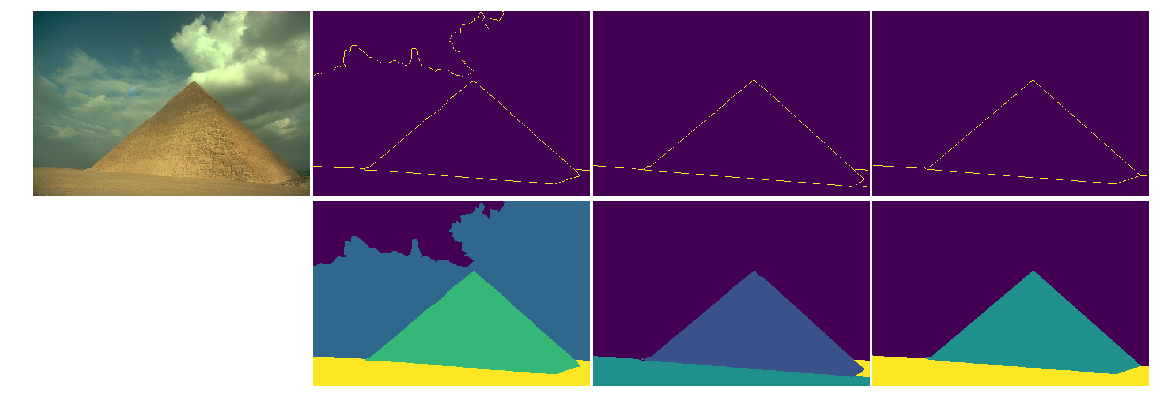

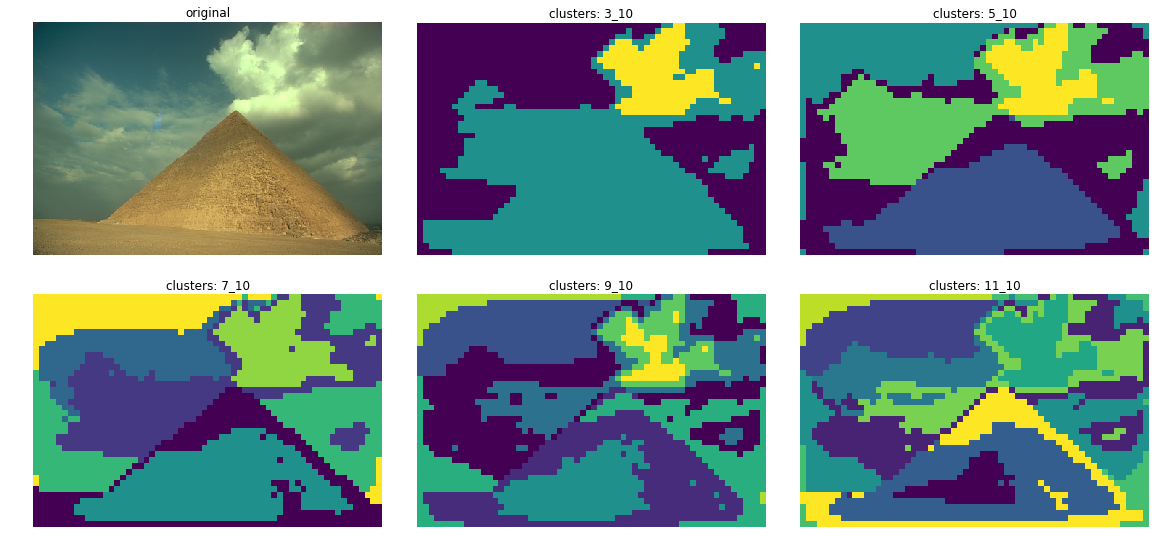

clusters: 3_10,groundTruth_1,groundTruth_2,groundTruth_3,best,worst,average
f_measure,0.41175,0.46765,0.46765,0.46765,0.41175,0.44901
entropy,0.61596,0.0,0.0,0.61596,0.0,0.20532


clusters: 5_10,groundTruth_1,groundTruth_2,groundTruth_3,best,worst,average
f_measure,0.30125,0.32609,0.32609,0.32609,0.30125,0.31781
entropy,0.61209,0.0,0.0,0.61209,0.0,0.20403


clusters: 7_10,groundTruth_1,groundTruth_2,groundTruth_3,best,worst,average
f_measure,0.23325,0.24719,0.24719,0.24719,0.23325,0.24254
entropy,0.59235,0.0,0.0,0.59235,0.0,0.19745


clusters: 9_10,groundTruth_1,groundTruth_2,groundTruth_3,best,worst,average
f_measure,0.18914,0.19401,0.19401,0.19401,0.18914,0.19239
entropy,0.59656,0.0,0.0,0.59656,0.0,0.19885


clusters: 11_10,groundTruth_1,groundTruth_2,groundTruth_3,best,worst,average
f_measure,0.1671,0.16368,0.16368,0.1671,0.16368,0.16482
entropy,0.59769,0.0,0.0,0.59769,0.0,0.19923


In [23]:
image_report("train", os.path.join(dirc_normalized_rbf, "run_1"), pyramid_image, ['3_10', '5_10', '7_10', '9_10', '11_10'])

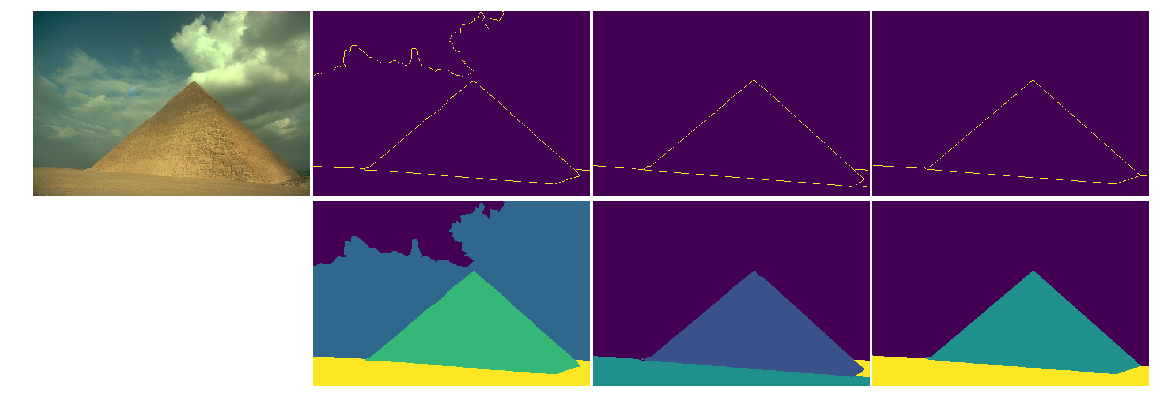

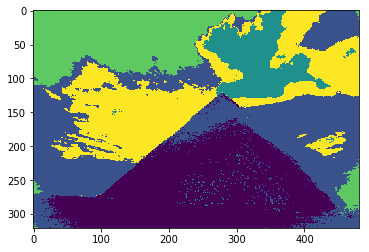

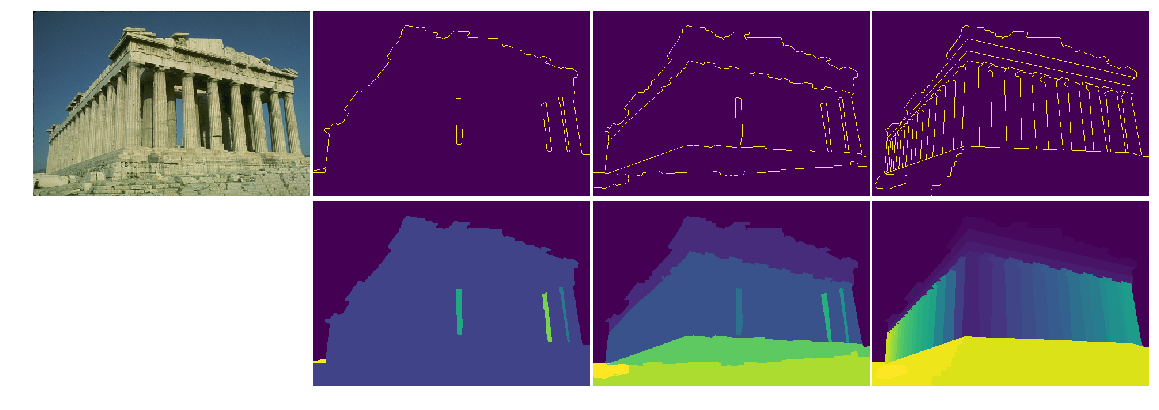

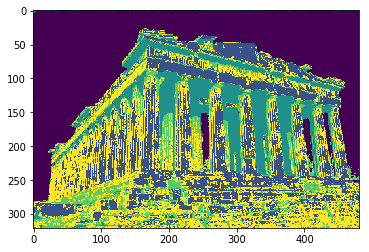

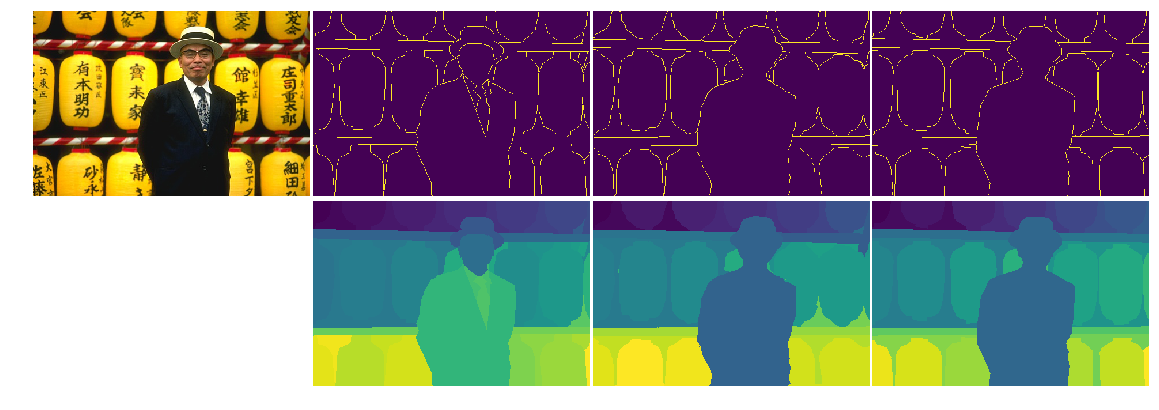

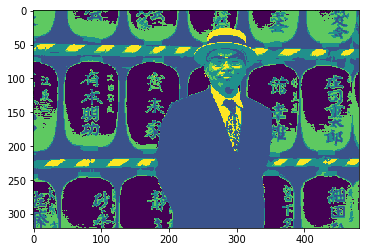

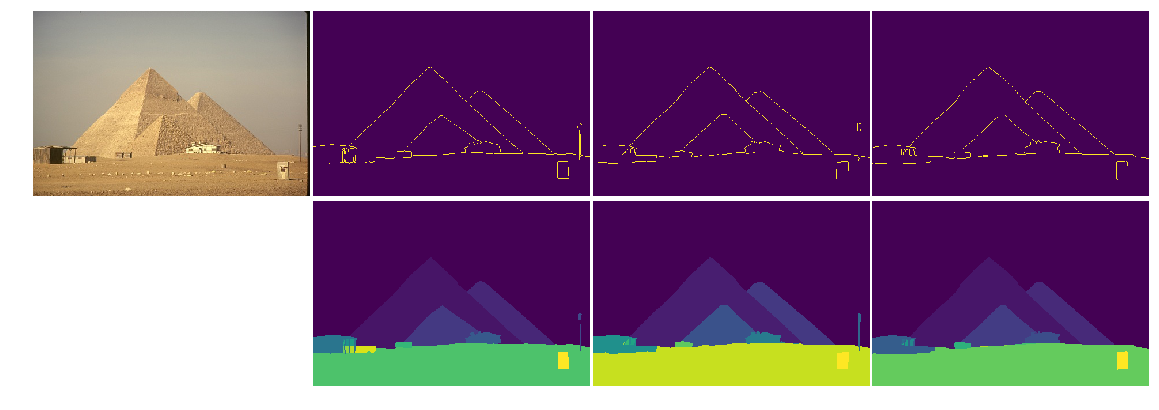

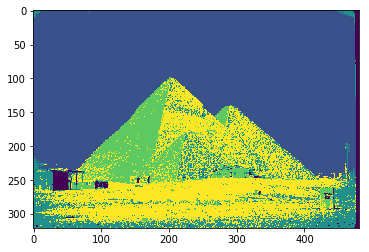

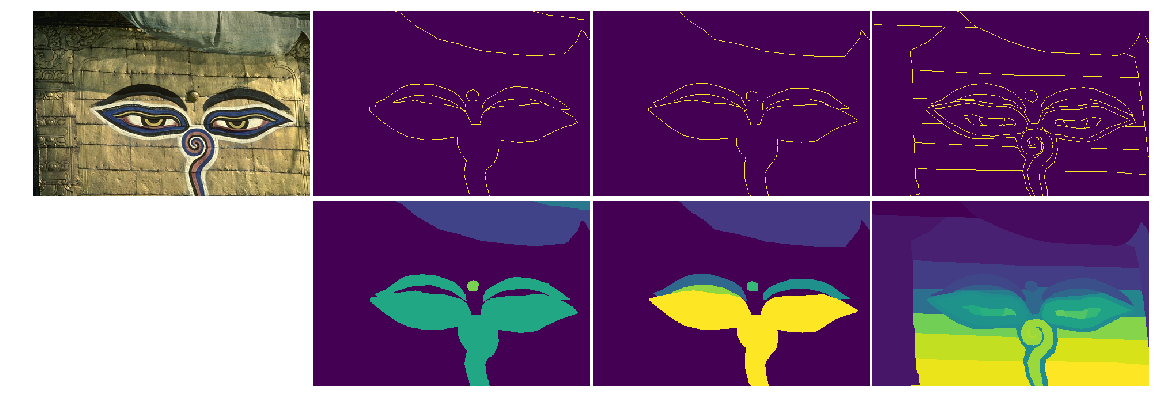

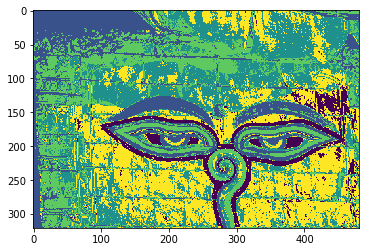

In [46]:
five_images = ['299091.jpg', '67079.jpg', '65019.jpg', '161062.jpg', '56028.jpg']

for image in five_images:
    show_image_groundTrue(os.path.join("train", image))
    img = np.load(os.path.join(os.path.join(data_dirc, "kmeans"), "run_1", "5", image + ".npy"))
    plt.imshow(img)
    plt.show()
    

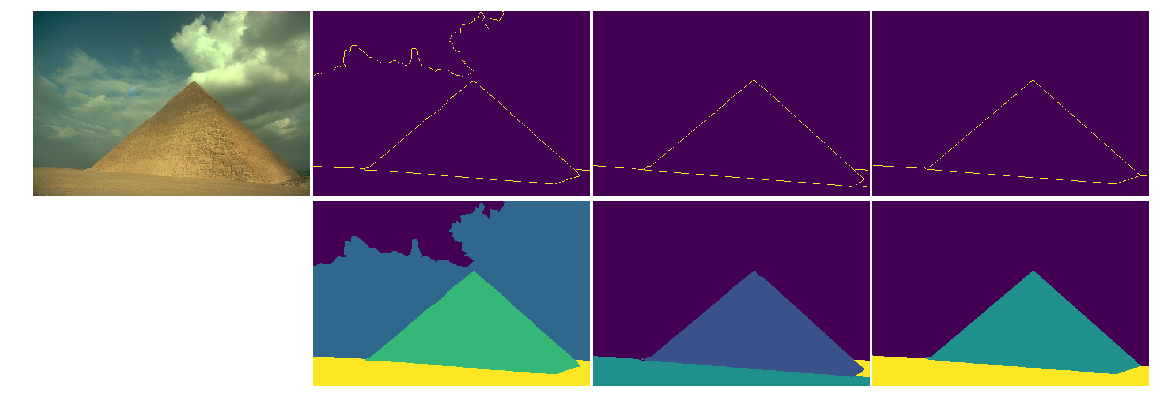

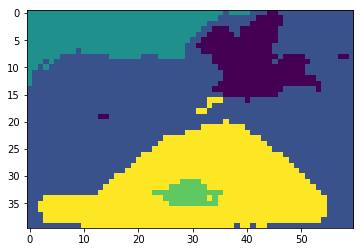

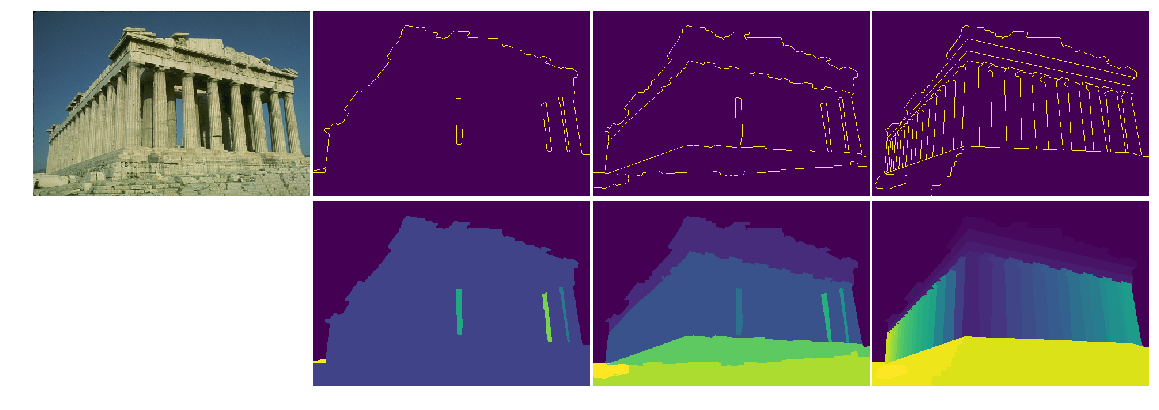

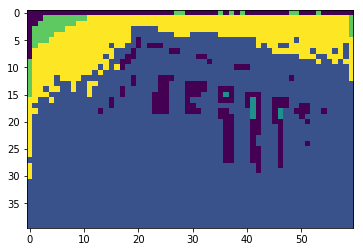

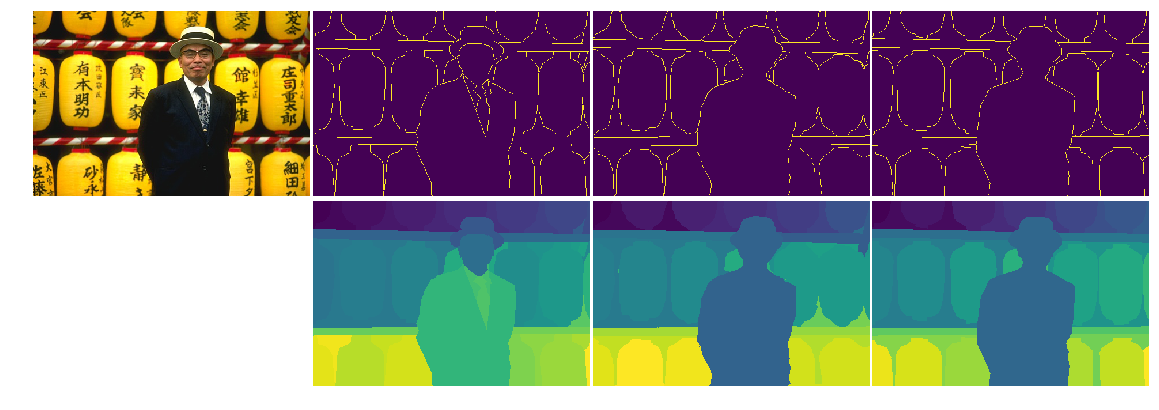

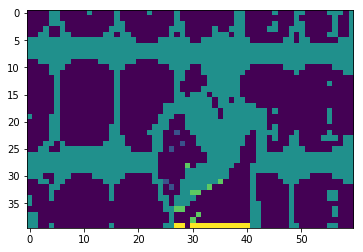

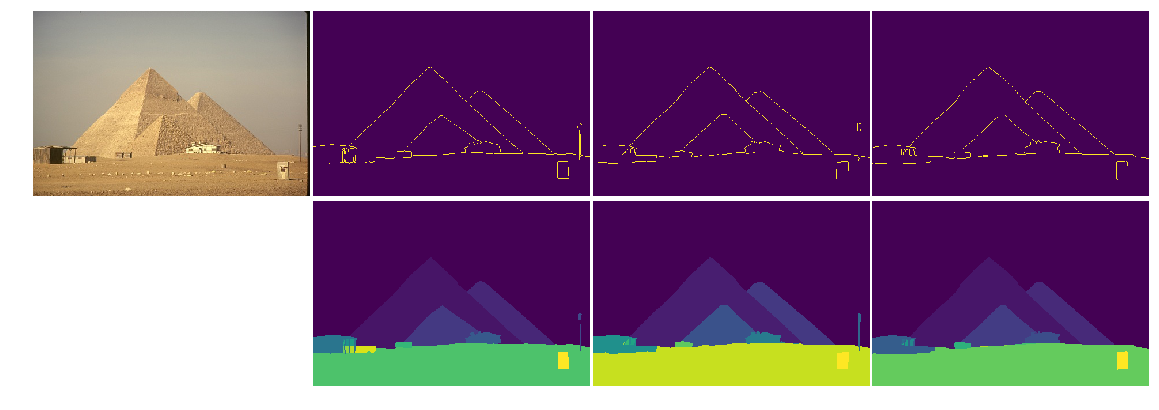

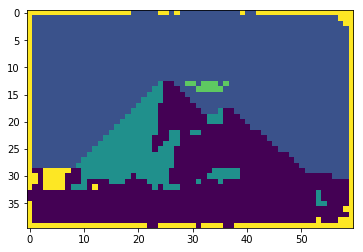

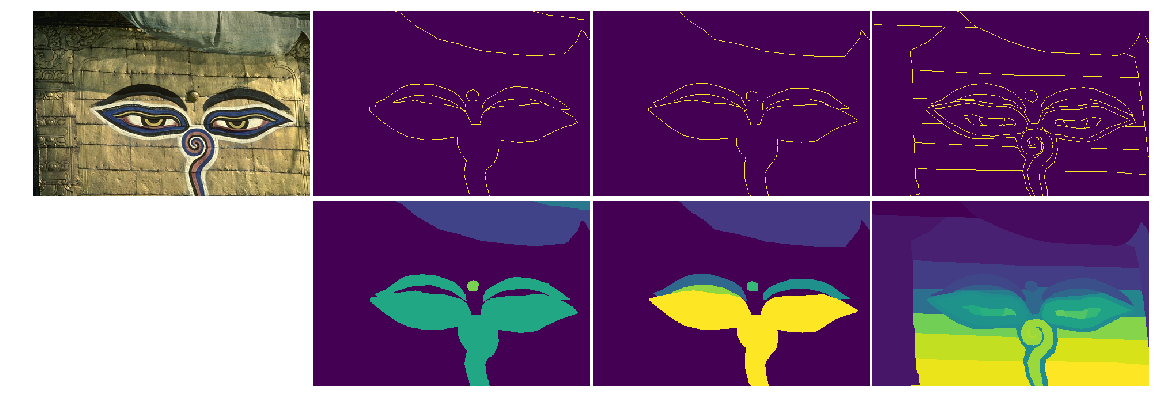

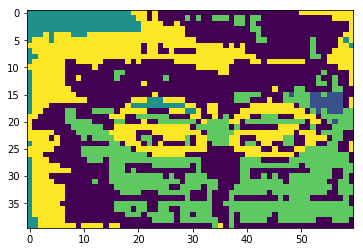

In [47]:
five_images = ['299091.jpg', '67079.jpg', '65019.jpg', '161062.jpg', '56028.jpg']

for image in five_images:
    show_image_groundTrue(os.path.join("train", image))
    img = np.load(os.path.join(dirc_normalized_nn, "run_1", "5_1", image + ".npy"))
    plt.imshow(img)
    plt.show()
    

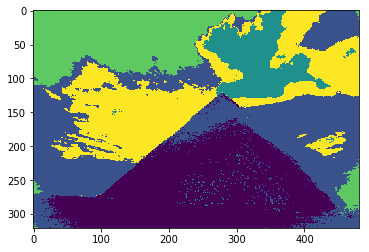

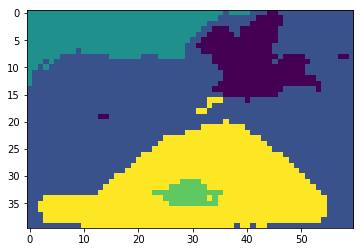

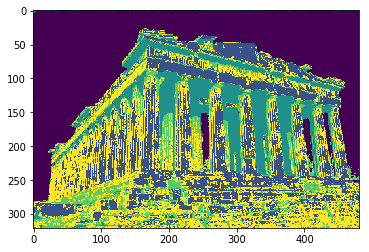

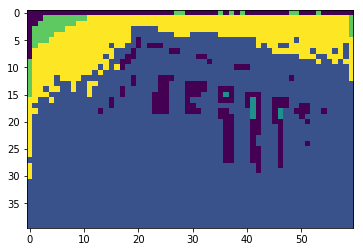

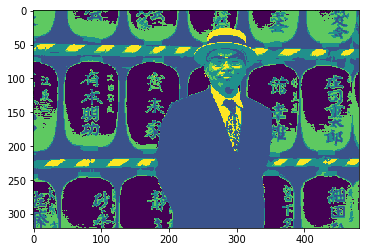

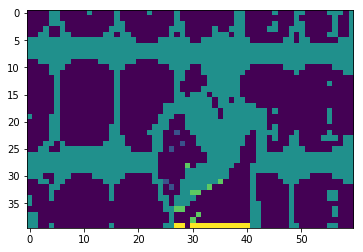

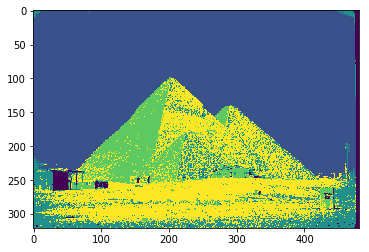

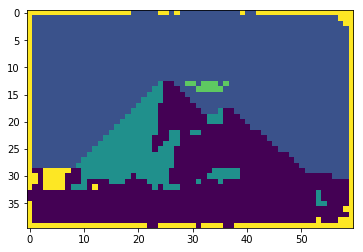

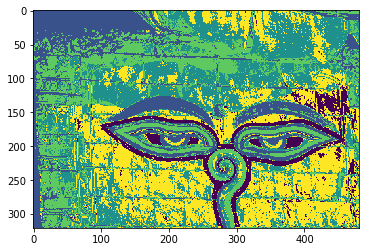

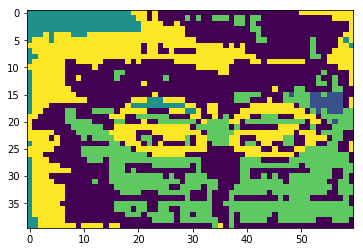

In [48]:
five_images = ['299091.jpg', '67079.jpg', '65019.jpg', '161062.jpg', '56028.jpg']

for image in five_images:
    img1 = np.load(os.path.join(os.path.join(data_dirc, "kmeans"), "run_1", "5", image + ".npy"))
    img2 = np.load(os.path.join(dirc_normalized_nn, "run_1", "5_1", image + ".npy"))
    plt.imshow(img1)
    plt.show()
    plt.imshow(img2)
    plt.show()
    print('\n\n\n\n\n\n')